<a href="https://colab.research.google.com/github/CeNe-99/Algorithms-for-massive-datasets-studyproject/blob/main/Finding_similar_items.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading and unziping the dataset.**

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "XXXX"
os.environ['KAGGLE_KEY'] = "XXXXX"
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip amazon-books-reviews.zip


Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 99% 1.05G/1.06G [00:04<00:00, 156MB/s]
100% 1.06G/1.06G [00:04<00:00, 266MB/s]
Archive:  amazon-books-reviews.zip
  inflating: Books_rating.csv        
  inflating: books_data.csv          


In [2]:
import multiprocess as mp
import pandas as pd
import re
import gc
!pip install datasketch
import datasketch as ds
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from tqdm import tqdm
import random
import zlib
from collections import defaultdict
import time
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 3.7 MB/s eta 0:00:00


**Gloable varible for sample size and settings**

In [3]:
# if True use only SAMPLE_SIZE else use whole dataset
USE_SAMPLE = False
# size of used samples
SAMPLE_SIZE = 1000

# MinHash, LSH & k-Shingle configuration
NUM_PERM = 128
SHINGLE_SIZE = 2

# Threshold for LSH similarity
LSH_THRESHOLD = 0.4


**Defining Class for MinHash and LSH**

In [4]:
class MinHash:
    """
    MinHash class.

    This class implements the MinHash algorithm to create a signature
    for a document, represented by a set of shingles.
    """
    def __init__(self, num_perm=128, seed=42):
        """
        Initializes a MinHash object.

        Args:
            num_perm (int): The number of permutations (hash functions)
            seed (int): The seed for the random number generator
        """
        # Number of permutations (hash functions)
        self.num_perm = num_perm
        # Maximum value for a 32-bit unsigned integer
        self.max_hash = (1 << 32) - 1
        # Initialize the signature with the maximum possible hash value for each permutation.
        self.signature = [self.max_hash] * num_perm
        # Seed for the random number generator to ensure reproducibility of hash functions
        self.seed = seed
        # Generate the hash functions used for creating the MinHash signature.
        self.hash_funcs = self._generate_hash_functions()

    def _generate_hash_functions(self) -> list[callable]:
        """
        Generates a list of hash functions.

        Each function is of the form (ax + b) % max_hash, where a and b
        are randomly generated constants.

        Returns:
            List[Callable]: A list of hash functions.
        """
        # Set random seed
        random.seed(self.seed)
        funcs = []
        # Generate 'num_perm' number of hash functions.
        for _ in range(self.num_perm):
            # Generate random parameters 'a' and 'b'
            # 'a' is chosen from 1 to max_hash, and 'b' from 0 to max_hash.
            a = random.randint(1, self.max_hash)
            b = random.randint(0, self.max_hash)
            # Append a lambda function that represents the hash function (ax + b) % max_hash.
            funcs.append(lambda x, a=a, b=b: (a * x + b) % self.max_hash)
        return funcs

    def update(self, shingles: set[str]):
        """
        Updates the MinHash signature based on a set of shingles.

        Args:
            shingles (Set[str]): The set of shingles to use for updating the signature.
        """
        # Iterate through each shingle in the set.
        for shingle in shingles:
            # Compute a 32-bit CRC (Cyclic Redundancy Check) hash for the shingle
            # and convert into positive value.
            shingle_hash = zlib.crc32(shingle.encode("utf-8")) & 0xffffffff
            # Iterate through each hash function and its corresponding signature element.
            for i, func in enumerate(self.hash_funcs):
                # Apply the current hash function to the shingle's hash value.
                val = func(shingle_hash)
                # If the resulting hash value is smaller than the current signature element,
                # update the signature element.
                if val < self.signature[i]:
                    self.signature[i] = val


class MinHashLSH:
    """
    MinHash LSH (Locality Sensitive Hashing) class for finding approximate nearest neighbors.

    It implements LSH using MinHash signatures to group similar documents into the same buckets.
    """
    def __init__(self, threshold: float = 0.8, num_perm: int = 128):
        """
        Initializes the MinHashLSH object.

        Args:
            threshold (float): The Jaccard similarity threshold above which documents are considered similar.
            num_perm (int): The number of permutations used in the MinHash signatures.
        """
        # Similarity threshold above which two documents are considered similar
        self.threshold = threshold
        # Number of permutations = length of the MinHash signature
        self.num_perm = num_perm
        # Determine the optimal number of bands and rows per band
        self.bands, self.rows_per_band = self._optimal_lsh_params()
        # Create one bucket dictionary per band to group similar signatures
        self.buckets = [defaultdict(list) for _ in range(self.bands)]
        # Store all inserted MinHash objects for later comparison
        self.data = {}

    def _optimal_lsh_params(self) -> tuple[int, int]:
        """
        Calculates optimal LSH parameters (bands and rows per band) to maximize the probability
        of a pair of documents with similarity >= threshold colliding in at least one bucket.

        Returns:
            Tuple[int, int]: A tuple containing the optimal number of bands and rows per band.
        """
        # Goal: choose b (bands) and r (rows per band) to best approximate the threshold
        best_diff = float('inf')
        best_b, best_r = 1, self.num_perm

        for b in range(1, self.num_perm + 1):
            # b needs to be a whole divider
            if self.num_perm % b != 0:
                continue
            r = self.num_perm // b
            # Approximate threshold
            approx_thresh = (1 / b) ** (1 / r)
            # calculate diffreance of approximate threshold and given threshold
            diff = abs(approx_thresh - self.threshold)
            # store if the diff is smaler than the previost ones
            if diff < best_diff:
                best_diff = diff
                best_b, best_r = b, r

        return best_b, best_r

    def _hash_band(self, band: tuple) -> int:
        """
        Hashes a band to determine which bucket it belongs to.

        Args:
            band (tuple): A tuple containing a portion of a MinHash signature.

        Returns:
            int: The hash value for the band.
        """
        # Convert the band tuple into bytes and apply a hash function (CRC32)
        band_bytes = str(band).encode('utf-8')
        return zlib.crc32(band_bytes) & 0xffffffff

    def insert(self, doc_id: str, minhash: MinHash):
        """
        Inserts a document's MinHash signature into the LSH index.

        Args:
            doc_id (str): The unique identifier for the document.
            minhash (MinHash): The MinHash signature of the document.
        """
        # Store the MinHash object for future comparison
        self.data[doc_id] = minhash

        # Go through all bands and insert band hashes into corresponding buckets
        for band_idx in range(self.bands):
            # Calculate the start and end index for this band in the minhash signature
            start = band_idx * self.rows_per_band
            end = start + self.rows_per_band

            # Extract the part of the signature corresponding to this band
            band = tuple(minhash.signature[start:end])

            # Hash the band to get a bucket ID
            hash_val = self._hash_band(band)

            # Add the document ID to the appropriate bucket
            self.buckets[band_idx][hash_val].append(doc_id)

    def query(self, minhash: MinHash) -> list[str]:
        """
        Queries the LSH index to find documents that are potentially similar to the given MinHash signature.

        Args:
            minhash (MinHash): The MinHash signature of the query document.

        Returns:
            List[str]: A list of document IDs that are likely similar to the query document.
        """
        # Find all candidate documents that share at least one band with the input
        candidates = set()
        for band_idx in range(self.bands):
            # Calculate the start and end index for this band in the minhash signature
            start = band_idx * self.rows_per_band
            end = start + self.rows_per_band
            # Extract the part of the signature corresponding to this band
            band = tuple(minhash.signature[start:end])
            # Hash the band to get a bucket ID
            hash_val = self._hash_band(band)

            # Add all documents in the same bucket to the candidates
            candidates.update(self.buckets[band_idx].get(hash_val, []))

        # Compare actual similarity with all candidates using Jaccard similarity
        similar_items = []
        for doc_id in candidates:
            other = self.data[doc_id]
            if self._jaccard(minhash.signature, other.signature) >= self.threshold:
                similar_items.append(doc_id)

        return similar_items

    def _jaccard(self, sig1: list[int], sig2: list[int]) -> float:
        """
        Calculates the Jaccard similarity between two MinHash signatures.

        Args:
            sig1 (List[int]): The first MinHash signature.
            sig2 (List[int]): The second MinHash signature.

        Returns:
            float: The Jaccard similarity between the two signatures.
        """
        # Calculate Jaccard similarity between two MinHash signatures
        assert len(sig1) == len(sig2)
        return sum(1 for a, b in zip(sig1, sig2) if a == b) / len(sig1)

**Defining funktions:**

In [5]:
def load_reviews(filepath: str) -> list[str]:
    """
    Loads reviews from a CSV file. Depending on the global USE_SAMPLE flag,
    it either loads the full dataset or just a sample of the specified size.
    Frees memory by deleting the DataFrame after extracting the review texts.

    Args:
        filepath (str): Path to the CSV file.

    Returns:
        List[str]: A list of review texts (full or sampled).
    """

    # Load only a sample of the data if USE_SAMPLE is True
    if USE_SAMPLE:
        # Read only the first SAMPLE_SIZE rows from the CSV to save time and memory
        df = pd.read_csv(filepath, usecols=["review/text"], nrows=SAMPLE_SIZE)
    else:
        # Read the full dataset if sampling is not enabled
        df = pd.read_csv(filepath, usecols=["review/text"])

    # Drop any rows where the review text is missing
    df.dropna(inplace=True)

    # Convert the DataFrame column to a list of strings
    reviews = df['review/text'].tolist()

    # Delete the DataFrame to free up RAM
    del df
    # trigger garbage collection to release memory
    gc.collect()

    return reviews


def preprocess_and_shingle(text: str) -> set[str]:
    """
    Preprocesses the input text and creates k-shingles the shingle size depends
    on the global SHINGLE_SIZE.

    Args:
        text (str): The input text to be preprocessed and shingled.

    Returns:
        Set[str]: A set of k-shingles created from the preprocessed text.
    """
    # Convert the text to lowercase
    text = text.lower()
    # Find all word tokens
    tokens = re.findall(r'\b\w+\b', text)
    # Filter out tokens that are digits or are in the list of English stop words.
    tokens = [t for t in tokens if not t.isdigit() and t not in ENGLISH_STOP_WORDS]
    # Create k-shingles of size SHINGLE_SIZE
    shingles = set([' '.join(tokens[i:i+SHINGLE_SIZE]) for i in range(len(tokens)-SHINGLE_SIZE+1)])
    return shingles


def create_minhash(shingles: set[str]) -> MinHash:
    """
    Creates a MinHash signature for a set of shingles.

    Args:
        shingles (Set[str]): A set of shingles.

    Returns:
        MinHash: The MinHash signature.
    """
    # Initialize a MinHash object with the specified number of permutations
    m = MinHash(num_perm=NUM_PERM)
    # Update the MinHash signature using the input set of shingles
    m.update(shingles)

    return m


def process_review(text: str) -> MinHash:
    """
    Processes a single review to generate its MinHash signature.

    This function is designed to be used with multiprocessing to parallelize
    the preprocessing and the MinHash creation process.

    Args:
        text (str): Review text.

    Returns:
        MinHash: The MinHash signature for the review.
    """
    # Preprocess the review text and convert it into a set of shingles
    shingles = preprocess_and_shingle(text)
    # Create a MinHash signature from the set of shingles
    return create_minhash(shingles)


def finding_similar_items(filepath: str) -> dict[str, list[str]]:
    """
    Finds similar items in a list of reviews using MinHash and LSH.

    Args:
        filepath (str): Path to the CSV file with reviews.

    Returns:
        Dict[str, List[str]]: Dictionary mapping doc IDs to lists of similar doc IDs.
    """
    # Load the reviews from the file
    reviews = load_reviews(filepath)

    # Create MinHash signatures in parallel
    with mp.Pool(processes=mp.cpu_count()) as pool:
        minhashes: list[MinHash] = list(tqdm(pool.imap(process_review, reviews), total=len(reviews)))

    # Initialize LSH with internal threshold logic
    lsh = MinHashLSH(threshold=LSH_THRESHOLD, num_perm=NUM_PERM)

    # Insert each document's MinHash into LSH
    for i, mh in enumerate(minhashes):
        lsh.insert(f"doc_{i}", mh)

    # Initialize an empty dictionary to store the results of similar items.
    # The keys will be document IDs, and the values will be lists of similar document IDs.
    similar_dict: dict[str, list[str]] = {}

    # Iterate through each review to find its similar documents in the LSH index.
    for i in range(len(reviews)):
        doc_id = f"doc_{i}"
        # Query the LSH index with the MinHash signature of the current document to find potential similar documents.
        result = lsh.query(minhashes[i])

        # Filter the query results to exclude the document itself
        similar_docs = [r for r in result if r != doc_id]

        # If any similar documents are found for the current document, add them to the similar_dict.
        if similar_docs:
            similar_dict[doc_id] = similar_docs

    return similar_dict

**Finding similar items**

In [ ]:
# Finding similar items by using selfwritten classes
result_dict = finding_similar_items("Books_rating.csv")
# print found similar items
print_similar_docs_with_text(result_dict, "Books_rating.csv", list(result_dict.keys())[:3])

# Finding similar items by using  classes from datasketch
result_dict_ds = finding_similar_items_ds("Books_rating.csv")
# print found similar items
print_similar_docs_with_text(result_dict_ds, "Books_rating.csv", list(result_dict_ds.keys())[:3])


  1%|          | 36175/2999992 [12:14<25:49:53, 31.87it/s]

**Functions for visualisation**

In [6]:
def print_similar_docs_with_text(similar_dict: dict[str, list[str]], filepath: str, doc_ids: str | list[str], max_chars: int = 300):
    """
    Loads reviews, maps document IDs to review texts, and prints the text for specified doc_ids and their similar documents.

    Args:
        similar_dict (dict): Dictionary with {doc_id: [similar doc_ids]}.
        filepath (str): Path to the CSV file to load review texts from.
        doc_ids (str or list): One or more document IDs (e.g., 'doc_12' or ['doc_12', 'doc_25']).
        max_chars (int): Maximum number of characters to display from each review.
    """
    # Load reviews from file
    reviews = load_reviews(filepath)

    # Build doc_id to review text mapping
    id_to_text = {f"doc_{i}": text for i, text in enumerate(reviews)}

    # Normalize input to a list
    if isinstance(doc_ids, str):
        doc_ids = [doc_ids]

    for doc_id in doc_ids:
        print(f"\nDocument: {doc_id}")
        original_text = id_to_text.get(doc_id, "[Text not found]")
        print(f"Review Text:\n{original_text[:max_chars]}...\n")

        similar_ids = similar_dict.get(doc_id)
        if similar_ids:
            print("Similar Documents:")
            for i, sim_id in enumerate(similar_ids, 1):
                sim_text = id_to_text.get(sim_id, "[Text not found]")
                print(f"  {i}. {sim_id}")
                print(f"     {sim_text[:max_chars]}...\n")
        else:
            print("  ➤ No similar documents found.")


def plot_benchmark_comparison(results: dict[int, dict[str, float]]):
    """
    Plots benchmark comparison results of two functions as line charts,
    skipping the first three x-axis ticks for clarity.

    Args:
        results (dict):
            Dictionary mapping sample size (int) to dict with keys 'custom' and 'ds'
            and values average durations (float in seconds).
    """
    # Sort results by sample size
    sorted_items = sorted(results.items())
    sample_sizes = [k for k, _ in sorted_items]
    durations_custom = [v['custom'] / 60 for _, v in sorted_items]  # convert to minutes
    durations_ds = [v['ds'] / 60 for _, v in sorted_items]

    # X ticks: skip first 3 but always show first tick
    ticks_to_show = [sample_sizes[0]] + sample_sizes[3:]

    plt.figure(figsize=(10, 6))

    # Plot both results
    plt.plot(sample_sizes, durations_custom, marker='o', linestyle='-', color='royalblue', label='finding_similar_items')
    plt.plot(sample_sizes, durations_ds, marker='x', linestyle='--', color='darkorange', label='finding_similar_items_ds')

    plt.xlabel('Sample size (number of reviews)')
    plt.ylabel('Average duration (minutes)')
    plt.grid(True)

    plt.xticks(ticks_to_show, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()




**Benchmark function**

In [ ]:
def benchmark(filepath: str, sample_sizes: list[int], num_runs: int = 3) -> dict[int, dict[str, float]]:
    """
    Benchmarks the finding_similar_items and finding_similar_items_ds functions with various sample sizes.

    Args:
        filepath (str): Path to the CSV file containing review texts.
        sample_sizes (list[int]): List of sample sizes to test.
        num_runs (int): Number of times to repeat each sample size for averaging.

    Returns:
        dict[int, dict[str, float]]: Mapping from sample size to dict with average runtimes in seconds for each function.
            Example:
            {
                100: {'custom': 12.5, 'ds': 10.8},
                500: {'custom': 58.1, 'ds': 52.7},
                ...
            }
    """
    global USE_SAMPLE, SAMPLE_SIZE
    results = {}

    for size in sample_sizes:
        durations_custom = []
        durations_ds = []

        print(f"\nBenchmarking with sample size: {size} for {num_runs} runs...")

        USE_SAMPLE = True
        SAMPLE_SIZE = size

        for run in range(num_runs):
            print(f"  Run {run + 1}/{num_runs} for finding_similar_items...")
            start_time = time.time()
            finding_similar_items(filepath)
            end_time = time.time()
            duration_custom = end_time - start_time
            durations_custom.append(duration_custom)
            print(f"    Run {run + 1} finished in {duration_custom:.2f} seconds.")

            print(f"  Run {run + 1}/{num_runs} for finding_similar_items_ds...")
            start_time = time.time()
            finding_similar_items_ds(filepath)
            end_time = time.time()
            duration_ds = end_time - start_time
            durations_ds.append(duration_ds)
            print(f"    Run {run + 1} finished in {duration_ds:.2f} seconds.")

        avg_custom = np.mean(durations_custom)
        avg_ds = np.mean(durations_ds)

        results[size] = {
            'custom': avg_custom,
            'ds': avg_ds
        }

        print(f"Finished sample size {size}. Average durations:")
        print(f"  finding_similar_items: {avg_custom:.2f} seconds")
        print(f"  finding_similar_items_ds: {avg_ds:.2f} seconds\n")

    return results

# start benchmark
bench_sizes = [100, 500, 1000, 5000, 10000, 20000]
benchmark_results = benchmark("Books_rating.csv",bench_sizes)


Benchmarking with sample size: 100 for 3 runs...
  Run 1/3 for finding_similar_items...


100%|██████████| 100/100 [00:01<00:00, 88.33it/s]


    Run 1 finished in 1.34 seconds.
  Run 1/3 for finding_similar_items_ds...


100%|██████████| 100/100 [00:00<00:00, 360.80it/s]


    Run 1 finished in 0.54 seconds.
  Run 2/3 for finding_similar_items...


100%|██████████| 100/100 [00:01<00:00, 90.00it/s]


    Run 2 finished in 1.37 seconds.
  Run 2/3 for finding_similar_items_ds...


100%|██████████| 100/100 [00:00<00:00, 366.35it/s]


    Run 2 finished in 0.56 seconds.
  Run 3/3 for finding_similar_items...


100%|██████████| 100/100 [00:01<00:00, 90.14it/s]


    Run 3 finished in 1.34 seconds.
  Run 3/3 for finding_similar_items_ds...


100%|██████████| 100/100 [00:00<00:00, 295.92it/s]


    Run 3 finished in 0.61 seconds.
Finished sample size 100. Average durations:
  finding_similar_items: 1.35 seconds
  finding_similar_items_ds: 0.57 seconds


Benchmarking with sample size: 500 for 3 runs...
  Run 1/3 for finding_similar_items...


100%|██████████| 500/500 [00:11<00:00, 44.42it/s]


    Run 1 finished in 11.61 seconds.
  Run 1/3 for finding_similar_items_ds...


100%|██████████| 500/500 [00:01<00:00, 352.68it/s]


    Run 1 finished in 1.81 seconds.
  Run 2/3 for finding_similar_items...


100%|██████████| 500/500 [00:09<00:00, 53.47it/s]


    Run 2 finished in 9.73 seconds.
  Run 2/3 for finding_similar_items_ds...


100%|██████████| 500/500 [00:01<00:00, 257.94it/s]


    Run 2 finished in 2.37 seconds.
  Run 3/3 for finding_similar_items...


100%|██████████| 500/500 [00:07<00:00, 64.43it/s]


    Run 3 finished in 8.03 seconds.
  Run 3/3 for finding_similar_items_ds...


100%|██████████| 500/500 [00:01<00:00, 379.65it/s]


    Run 3 finished in 1.69 seconds.
Finished sample size 500. Average durations:
  finding_similar_items: 9.79 seconds
  finding_similar_items_ds: 1.96 seconds


Benchmarking with sample size: 1000 for 3 runs...
  Run 1/3 for finding_similar_items...


100%|██████████| 1000/1000 [00:15<00:00, 64.18it/s]


    Run 1 finished in 15.94 seconds.
  Run 1/3 for finding_similar_items_ds...


100%|██████████| 1000/1000 [00:02<00:00, 364.93it/s]


    Run 1 finished in 3.30 seconds.
  Run 2/3 for finding_similar_items...


100%|██████████| 1000/1000 [00:18<00:00, 55.00it/s]


    Run 2 finished in 18.67 seconds.
  Run 2/3 for finding_similar_items_ds...


100%|██████████| 1000/1000 [00:03<00:00, 306.68it/s]


    Run 2 finished in 3.91 seconds.
  Run 3/3 for finding_similar_items...


100%|██████████| 1000/1000 [00:15<00:00, 65.37it/s]


    Run 3 finished in 15.65 seconds.
  Run 3/3 for finding_similar_items_ds...


100%|██████████| 1000/1000 [00:02<00:00, 369.24it/s]


    Run 3 finished in 3.27 seconds.
Finished sample size 1000. Average durations:
  finding_similar_items: 16.75 seconds
  finding_similar_items_ds: 3.49 seconds


Benchmarking with sample size: 5000 for 3 runs...
  Run 1/3 for finding_similar_items...


100%|██████████| 5000/5000 [01:23<00:00, 59.95it/s]


    Run 1 finished in 84.92 seconds.
  Run 1/3 for finding_similar_items_ds...


100%|██████████| 5000/5000 [00:22<00:00, 224.23it/s]


    Run 1 finished in 24.52 seconds.
  Run 2/3 for finding_similar_items...


100%|██████████| 5000/5000 [01:14<00:00, 66.91it/s]


    Run 2 finished in 76.36 seconds.
  Run 2/3 for finding_similar_items_ds...


100%|██████████| 5000/5000 [00:17<00:00, 283.89it/s]


    Run 2 finished in 20.24 seconds.
  Run 3/3 for finding_similar_items...


100%|██████████| 5000/5000 [01:20<00:00, 61.74it/s]


    Run 3 finished in 82.74 seconds.
  Run 3/3 for finding_similar_items_ds...


100%|██████████| 5000/5000 [00:15<00:00, 314.04it/s]


    Run 3 finished in 18.04 seconds.
Finished sample size 5000. Average durations:
  finding_similar_items: 81.34 seconds
  finding_similar_items_ds: 20.93 seconds


Benchmarking with sample size: 10000 for 3 runs...
  Run 1/3 for finding_similar_items...


100%|██████████| 10000/10000 [02:26<00:00, 68.49it/s]


    Run 1 finished in 149.32 seconds.
  Run 1/3 for finding_similar_items_ds...


100%|██████████| 10000/10000 [00:33<00:00, 301.47it/s]


    Run 1 finished in 37.34 seconds.
  Run 2/3 for finding_similar_items...


100%|██████████| 10000/10000 [02:18<00:00, 72.22it/s]


    Run 2 finished in 142.28 seconds.
  Run 2/3 for finding_similar_items_ds...


100%|██████████| 10000/10000 [00:32<00:00, 309.37it/s]


    Run 2 finished in 36.62 seconds.
  Run 3/3 for finding_similar_items...


100%|██████████| 10000/10000 [02:20<00:00, 71.00it/s]


    Run 3 finished in 144.46 seconds.
  Run 3/3 for finding_similar_items_ds...


100%|██████████| 10000/10000 [00:41<00:00, 238.47it/s]


    Run 3 finished in 47.42 seconds.
Finished sample size 10000. Average durations:
  finding_similar_items: 145.36 seconds
  finding_similar_items_ds: 40.46 seconds


Benchmarking with sample size: 20000 for 3 runs...
  Run 1/3 for finding_similar_items...


100%|██████████| 20000/20000 [04:49<00:00, 69.03it/s]


    Run 1 finished in 293.13 seconds.
  Run 1/3 for finding_similar_items_ds...


100%|██████████| 20000/20000 [01:04<00:00, 311.74it/s]


    Run 1 finished in 73.62 seconds.
  Run 2/3 for finding_similar_items...


100%|██████████| 20000/20000 [04:39<00:00, 71.51it/s]


    Run 2 finished in 283.73 seconds.
  Run 2/3 for finding_similar_items_ds...


100%|██████████| 20000/20000 [01:05<00:00, 303.45it/s]


    Run 2 finished in 74.14 seconds.
  Run 3/3 for finding_similar_items...


100%|██████████| 20000/20000 [04:38<00:00, 71.84it/s]


    Run 3 finished in 282.09 seconds.
  Run 3/3 for finding_similar_items_ds...


100%|██████████| 20000/20000 [01:03<00:00, 315.84it/s]


    Run 3 finished in 72.56 seconds.
Finished sample size 20000. Average durations:
  finding_similar_items: 286.32 seconds
  finding_similar_items_ds: 73.44 seconds



**Plot results**

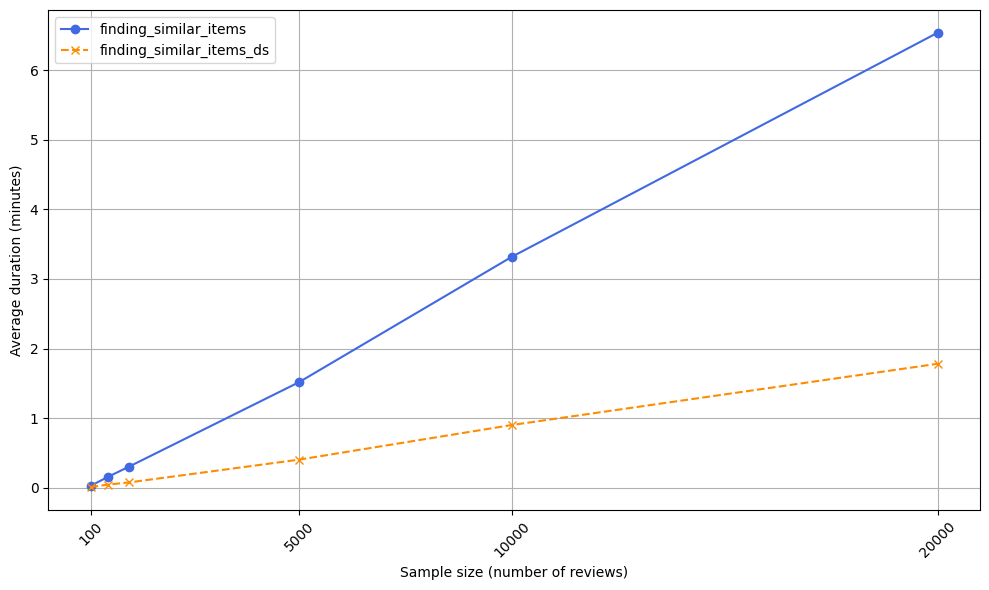

In [ ]:
plot_benchmark_comparison(benchmark_results)

**Functions with datasketch**

In [ ]:
def create_minhash_ds(shingles: set[str]) -> MinHash:
    """
    Creates a MinHash signature for a set of shingles.

    Args:
        shingles (Set[str]): A set of shingles.

    Returns:
        MinHash: The MinHash signature.
    """
    # Initialize a MinHash object with the specified number of permutations
    m = ds.MinHash(num_perm=NUM_PERM)

    # Update the MinHash signature using the input set of shingles
    for shingle in shingles:
        m.update(shingle.encode('utf8'))
    return m


def process_review_ds(text: str) -> MinHash:
    """
    Processes a single review to generate its MinHash signature.

    This function is designed to be used with multiprocessing to parallelize
    the preprocessing and the MinHash creation process.

    Args:
        text (str): Review text.

    Returns:
        MinHash: The MinHash signature for the review.
    """
    # Preprocess the review text and convert it into a set of shingles
    shingles = preprocess_and_shingle(text)
     # Create a MinHash signature from the set of shingles
    return create_minhash_ds(shingles)


def finding_similar_items_ds(filepath: str) -> dict[str, list[str]]:
    """
    Finds similar items in a list of reviews using MinHash and LSH.

    Args:
        reviews (List[str]): List of review texts.

    Returns:
        Dict[str, List[str]]: Dictionary mapping doc IDs to lists of similar doc IDs.
    """
    # Load the reviews from the specified file path.
    reviews = load_reviews(filepath)

    # Use a multiprocessing pool to process reviews in parallel.
    with mp.Pool(processes=mp.cpu_count()) as pool:
        # Create MinHash signatures using multiprocessing
        minhashes: list[MinHash] = list(tqdm(pool.imap(process_review_ds, reviews), total=len(reviews)))

    # Initialize a MinHash LSH (Locality Sensitive Hashing) object.
    lsh = ds.MinHashLSH(threshold=LSH_THRESHOLD, num_perm=NUM_PERM)

    # Insert each MinHash signature into the LSH index.
    for i, mh in enumerate(minhashes):
        lsh.insert(f"doc_{i}", mh)

    # Initialize an empty dictionary to store the results of similar items.
    # The keys will be document IDs, and the values will be lists of similar document IDs.
    similar_dict: dict[str, list[str]] = {}

    # Iterate through each review to find its similar documents in the LSH index.
    for i in range(len(reviews)):
        doc_id = f"doc_{i}"
        # Query the LSH index with the MinHash signature of the current document to find potential similar documents.
        result = lsh.query(minhashes[i])

        # Filter the query results to exclude the document itself, as it will always be similar to itself.
        similar_docs = [r for r in result if r != doc_id]

        # If any similar documents are found for the current document, add them to the similar_dict.
        if similar_docs:
            similar_dict[doc_id] = similar_docs

    return similar_dict

**Compare diffrent thresholds and shingle sizes**

In [ ]:
def compare_similarity_methods(filepath: str, thresholds: list[float], shingles_list: list[int]) -> dict:
    global LSH_THRESHOLD, SHINGLE_SIZE, NUM_PERM

    results = {}

    for threshold in thresholds:
        for shingle_size in shingles_list:
            LSH_THRESHOLD = threshold
            SHINGLE_SIZE = shingle_size

            similar_ds = finding_similar_items_ds(filepath)
            similar_custom = finding_similar_items(filepath)

            keys_ds = set(similar_ds.keys())
            keys_custom = set(similar_custom.keys())
            common_keys = keys_ds.intersection(keys_custom)

            total_pairs_ds = sum(len(v) for v in similar_ds.values())
            total_pairs_custom = sum(len(v) for v in similar_custom.values())

            common_pairs = 0
            for k in common_keys:
                common_pairs += len(set(similar_ds[k]).intersection(set(similar_custom[k])))

            results[(threshold, shingle_size)] = {
                'num_docs_ds': len(keys_ds),
                'num_docs_custom': len(keys_custom),
                'common_docs': len(common_keys),
                'pairs_ds': total_pairs_ds,
                'pairs_custom': total_pairs_custom,
                'common_pairs': common_pairs
            }

    return results


def plot_similarity_comparison(results: dict):

    thresholds = sorted(set(k[0] for k in results.keys()))
    shingles = sorted(set(k[1] for k in results.keys()))


    # Plot for number of docs with similar items (DS vs Custom)
    plt.figure(1)
    for shingle in shingles:
        docs_ds = [results[(thresh, shingle)]['num_docs_ds'] for thresh in thresholds]
        docs_custom = [results[(thresh, shingle)]['num_docs_custom'] for thresh in thresholds]

        plt.plot(thresholds, docs_ds, marker='o', label=f'DS docs, Shingle={shingle}')
        plt.plot(thresholds, docs_custom, marker='x', linestyle='--', label=f'Custom docs, Shingle={shingle}')

    plt.xlabel("Threshold")
    plt.ylabel("Number of documents")
    plt.legend()
    plt.grid(True)

    # Plot for number of similar pairs found
    plt.figure(2)
    for shingle in shingles:
        pairs_ds = [results[(thresh, shingle)]['pairs_ds'] for thresh in thresholds]
        pairs_custom = [results[(thresh, shingle)]['pairs_custom'] for thresh in thresholds]
        common_pairs = [results[(thresh, shingle)]['common_pairs'] for thresh in thresholds]

        plt.plot(thresholds, pairs_ds, marker='o', label=f'DS pairs, Shingle={shingle}')
        plt.plot(thresholds, pairs_custom, marker='x', linestyle='--', label=f'Custom pairs, Shingle={shingle}')
        plt.plot(thresholds, common_pairs, marker='s', linestyle=':', label=f'Common pairs, Shingle={shingle}')

    plt.xlabel("Threshold")
    plt.ylabel("Number of pairs")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
thresholds = [0.3, 0.5, 0.7, 0.9]
shingles = [3, 5, 7]

results = compare_similarity_methods("Books_rating.csv", thresholds, shingles)


100%|██████████| 1000/1000 [00:17<00:00, 57.50it/s]


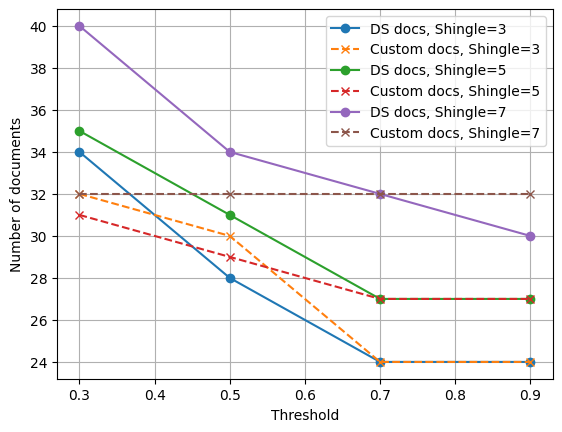

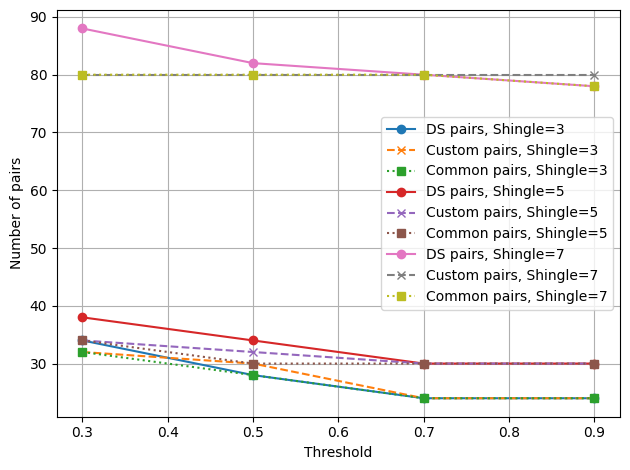

In [ ]:
plot_similarity_comparison(results)